In [1]:
from pyzx.rules import*
import pyzx as zx
import random
from pyzx.graph.base import BaseGraph, VT, ET
from typing import List, Callable, Optional, Union, Generic, Tuple, Dict, Iterator, cast
from typing import TypeVar
from copy import deepcopy
from pdb import set_trace as st
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
import sys
module_path = r"path"
sys.path.append(module_path)
import riu_simplify

In [3]:
import importlib
importlib.reload(riu_simplify)

<module 'riu_simplify' from 'C:\\Users\\tenni\\python3user\\Qiskit\\QCO\\pyzx_utils\\module\\riu_simplify.py'>

In [4]:
MatchObject = TypeVar("MatchObject")
RewriteOutputType = Tuple[Dict[Tuple[VT,VT],List[int]], List[VT], List[ET], bool]

In [5]:
rewrites = {
            "name":"Pyzx_version",
            "id": {
                "name": "id",
                "match": zx.rules.match_ids_parallel,
                "apply": zx.rules.remove_ids,
            },
            "lcomp": {
                "name": "lcomp",
                "match": zx.rules.match_lcomp_parallel,
                "apply": zx.rules.lcomp,
            },
            "piv": {
                "name": "pivot",
                "match": zx.rules.match_pivot_parallel,
                "apply": zx.rules.pivot,
            },
            "pivb": {
                "name": "pivot_boundary",
                "match": zx.rules.match_pivot_boundary,
                "apply": zx.rules.pivot,
            },
            "pivg": {
                "name": "pivot_gadget",
                "match": zx.rules.match_pivot_gadget,
                "apply": zx.rules.pivot
            }
        }

In [6]:
rewrites_riu = {
            "name":"Riu_version",
            "id": {
                "name": "id",
                "match": riu_simplify.match_ids,
                "apply": riu_simplify.remove_ids,
            },
            "lcomp": {
                "name": "lcomp",
                "match": riu_simplify.match_lcomp,
                "apply": riu_simplify.lcomp,  
            },
            "piv": {
                "name": "pivot",
                "match": riu_simplify.match_pivot_parallel, 
                "apply": riu_simplify.pivot,
            },
            "pivb": {
                "name": "pivot_boundary",
                "match": riu_simplify.match_pivot_boundary,
                "apply": riu_simplify.pivot,
            },
            "pivg": {
                "name": "pivot_gadget",
                "match": riu_simplify.match_pivot_gadget,
                "apply": riu_simplify.pivot_gadget
            }
        }

In [7]:
def apply_simp(
    g:BaseGraph[VT, ET],
    rewrite_function:Callable[..., List[MatchObject]],
    match,
):
    g1 = deepcopy(g)
    #st()
    etab, rem_verts, rem_edges, check_isolated_vertices = \
    rewrite_function(g, match)
    g1.add_edge_table(etab)
    g1.remove_edges(rem_edges)
    g1.remove_vertices(rem_verts)
    if check_isolated_vertices: g1.remove_isolated_vertices()
    return g1

def apply_riu_pivot(
    g:BaseGraph,
    rewrite_function:Callable[..., List[MatchObject]],
    random_match:Tuple,
    info_matches:dict,
):
    g1 = deepcopy(g)
    etab, rem_verts, rem_edges, check_isolated_vertices = \
    rewrite_function(g, random_match[0], random_match[1], info_matches)
    g1.add_edge_table(etab)
    g1.remove_edges(rem_edges)
    g1.remove_vertices(rem_verts)
    if check_isolated_vertices: g1.remove_isolated_vertices()
    return g1

In [21]:
def random_simp(graph, rewrites):
    g = deepcopy(graph)
    tmp = [random.random() for _ in range(3)]
    p1, p2, p3 = sorted(tmp)
    print(f"p1:{p1}, p2:{p2}, p3:{p3}\n")

    while True:
        if len(rewrites["id"]["match"](g)) == len(rewrites["lcomp"]["match"](g)) == len(rewrites["piv"]["match"](g)) == 0:
            break
        
        p = random.random()
        
        if p <= p1:
            matches = rewrites["id"]["match"](g)
            if len(matches) == 0: 
                continue
            r_match = random.choice(matches)
            print("id", r_match)
            g = apply_simp(g, rewrites["id"]["apply"], [r_match])

        if p > p2 and p < p3:
            matches = rewrites["lcomp"]["match"](g)
            if len(matches) == 0: 
                continue
            r_match = random.choice(matches)
            print("lcomp", r_match)
            g = apply_simp(g, rewrites["lcomp"]["apply"], [r_match])

        if p >= p3 and p <= 1:
            matches = rewrites["piv"]["match"](g)
            if len(matches) == 0: 
                continue
            r_match = random.choice(matches)
            print("pivot", r_match)
            g = apply_simp(g, rewrites["piv"]["apply"], [r_match])
    
    return g

In [ ]:
def riu_random_simp(graph, rewrites):
    g = deepcopy(graph)
    tmp = [random.random() for _ in range(3)]
    p1, p2, p3 = sorted(tmp)
    print(f"p1:{p1}, p2:{p2}, p3:{p3}\n")

    while True:
        if len(rewrites["id"]["match"](g)) == len(rewrites["lcomp"]["match"](g)) == len(rewrites["piv"]["match"](g)) == 0:
            break
        
        p = random.random()
        
        if p <= p1:
            matches = rewrites["id"]["match"](g)
            if len(matches) == 0: 
                continue
            r_match = random.choice(matches)
            neighbors = list(g.neighbors(r_match))
            print("id", r_match)
            g = apply_simp(g, rewrites["id"]["apply"], r_match)
            #riu version における id apply 後の spider fusion を apply します。
            types = g.types()
            if types[neighbors[0]] != zx.VertexType.BOUNDARY and \
                types[neighbors[1]] != zx.VertexType.BOUNDARY:
                print(f"spider fusion:({neighbors})")
                riu_simplify.apply_rule(g, *riu_simplify.spider_fusion(neighbors))

        if p > p2 and p < p3:
            matches = rewrites["lcomp"]["match"](g)
            if len(matches) == 0: 
                continue
            r_match = random.choice(matches)
            print("lcomp", r_match)
            g = apply_simp(g, rewrites["lcomp"]["apply"], r_match) # riuさんの, lcomp は、node number(int) が引数

        if p >= p3 and p <= 1:
            """matches = rewrites["piv"]["match"](g)
            if len(matches) == 0: 
                Flag3 = False
                continue
            r_match = random.choice(list(matches.keys()))
            print("pivot", r_match, matches[r_match])
            g = apply_riu_pivot(g, rewrites["piv"]["apply"], r_match, matches)
            Flag3 = True"""
            pivot_info_dict = riu_simplify.create_pivot_info_dict(g)
            if not pivot_info_dict:
                print("no match for pivot found")
                continue
            r_match = random.choice(list(pivot_info_dict.keys()))
            node1, node2 = r_match
            pv_type = pivot_info_dict[r_match][-1]
            # 0: pivot, 1: pvb, 2: pvg
            if pv_type == 0:
                riu_simplify.apply_rule(g, *riu_simplify.pivot(g, node1, node2, pivot_info_dict))
            else:
                try:
                    riu_simplify.apply_rule(g, *riu_simplify.pivot_gadget(g, node1, node2))
                    # pivot_gadget の中の、phase_tracking がなんか pyzx から消えているので、今はこうしてます。
                except:
                    pass
    return g

In [9]:
def to_graph_like(circ):
    # convert zx-graph into graph-like form
    g = deepcopy(circ)
    zx.simplify.to_gh(g)
    zx.simplify.spider_simp(g, quiet=True)
    return g


def post_process(g):
    g1 = deepcopy(g)
    circ = zx.extract_circuit(g1)
    #circ = zx.basic_optimization(g1)
    return circ

def id_check(original_circ, simplified_circ):
    t1 = original_circ.to_tensor()
    t2 = simplified_circ.to_tensor()
    print(zx.compare_tensors(t1, t2))

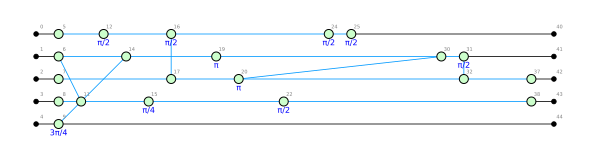

In [10]:
qubit = 5
depth = 20
random.seed(20)
circ = zx.generate.cliffordT(qubit, depth)
zx.draw_matplotlib(circ)
g = to_graph_like(circ)
zx.draw_matplotlib(g, labels=True)

# PyZX バージョンのrewrite

pivot (7, 17, [2], [])
pivot (32, 37, [], [42])
id (5, 0, 12, 2)
id (8, 3, 11, 2)
id (38, 22, 43, 2)
pivot (14, 19, [], [])
pivot (6, 30, [1], [])
lcomp (16, [12, 17, 24])
lcomp (24, [25, 12, 17])
pivot (20, 32, [], [42])


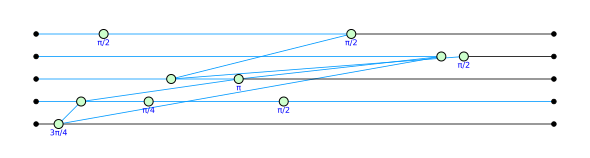

In [20]:
g1 = random_simp(g, rewrites)
g1.normalize()
zx.draw_matplotlib(g1)

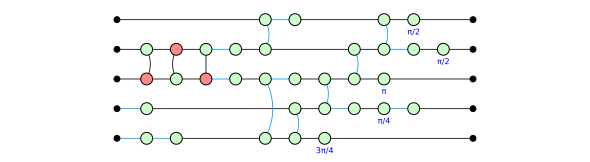

In [15]:
circ1 = post_process(g1)
zx.draw_matplotlib(circ1)

In [16]:
id_check(circ, circ1)

False


# Riu さんバージョン


pivot (6, 11) ((1,), (), 0)
lcomp 16
pivot (32, 37) ((), (42,), 0)
pivot (20, 32) ((), (42,), 0)
id 38
id 30
id 7
pivot (8, 14) ((3,), (), 0)
id 5


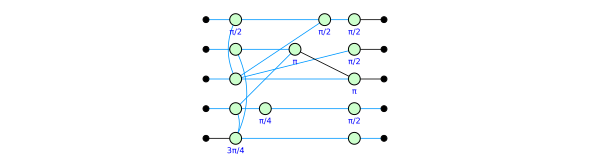

In [17]:
g2 = riu_random_simp(g, rewrites_riu)
g2.normalize()
zx.draw_matplotlib(g2)

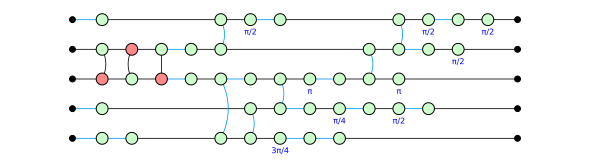

In [18]:
circ2 = post_process(g2)
zx.draw_matplotlib(circ2)

In [19]:
id_check(circ, circ2)

False
